In [2]:
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import keras
from keras.models import Sequential
from keras import layers
from keras import optimizers
from keras import backend as K
from keras import regularizers

import torch
from torch.utils.data import DataLoader


from physionet_processing import spectrogram, transformed_stats
from physionet_generator import DataGenerator


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
data_root = os.path.normpath("C:\\Users\\nazrulsa\\Desktop\\Data-Fusion\\")  # Base path for MIMIC dataset

records_file = os.path.join('.', 'records_filtered.csv')  

# Fix: Column names must be strings
records_df = pd.read_csv(records_file, names=['subject_id', 'study_id', 'icd_code', 'icd_title', 'path'])

# Encoding the labels
label_set = list(sorted(records_df['icd_title'].unique()))
encoder = LabelEncoder().fit(label_set)
label_set_codings = encoder.transform(label_set)
records_df = records_df.assign(encoded=encoder.transform(records_df['icd_title']))

print('Unique labels:', encoder.inverse_transform(label_set_codings))
print('Unique codings:', label_set_codings)
print('Dataset labels:\n', records_df[['subject_id', 'icd_title', 'encoded']].head())

# Splitting the dataset
test_split = 0.33
idx = np.arange(records_df.shape[0])
id_train, id_val, _, _ = train_test_split(idx, idx, 
                                         test_size=test_split,
                                         shuffle=True,
                                         random_state=123)

partition = {
    'train': list(records_df.iloc[id_train]['study_id']),  
    'validation': list(records_df.iloc[id_val]['study_id'])
}

labels = dict(zip(records_df['study_id'], records_df['encoded']))

# Printing sample data
for idx in range(5):
    study_id = records_df.iloc[idx]['study_id']
    path = os.path.join(data_root, records_df.iloc[idx]['path'])  
    label = labels[study_id]
    print(f"Study ID: {study_id}, Path: {path}, Label: {label}")

Unique labels: ['Atrial Fibrillation' 'Myocardial infarction' 'Ventricular tachycardia']
Unique codings: [0 1 2]
Dataset labels:
    subject_id              icd_title  encoded
0    10007058  Myocardial infarction        1
1    10007058  Myocardial infarction        1
2    10007058  Myocardial infarction        1
3    10007058  Myocardial infarction        1
4    10007058  Myocardial infarction        1
Study ID: 41688028, Path: C:\Users\nazrulsa\Desktop\Data-Fusion\files/p1000/p10007058/s41688028/41688028, Label: 1
Study ID: 47527771, Path: C:\Users\nazrulsa\Desktop\Data-Fusion\files/p1000/p10007058/s47527771/47527771, Label: 1
Study ID: 47979034, Path: C:\Users\nazrulsa\Desktop\Data-Fusion\files/p1000/p10007058/s47979034/47979034, Label: 1
Study ID: 40778825, Path: C:\Users\nazrulsa\Desktop\Data-Fusion\files/p1000/p10007058/s40778825/40778825, Label: 1
Study ID: 49692275, Path: C:\Users\nazrulsa\Desktop\Data-Fusion\files/p1000/p10007058/s49692275/49692275, Label: 1


In [4]:
df_stat = records_df.groupby('icd_title').agg('count').reset_index()
df_stat = df_stat[['icd_title', 'study_id']]  
df_stat.columns = ['Class', 'Recordings']  
df_stat = df_stat.assign(percent=(100 * np.around(df_stat['Recordings'] / records_df.shape[0], 2)).astype(int))  
print(df_stat)

                     Class  Recordings  percent
0      Atrial Fibrillation        6137       38
1    Myocardial infarction        7726       48
2  Ventricular tachycardia        2298       14


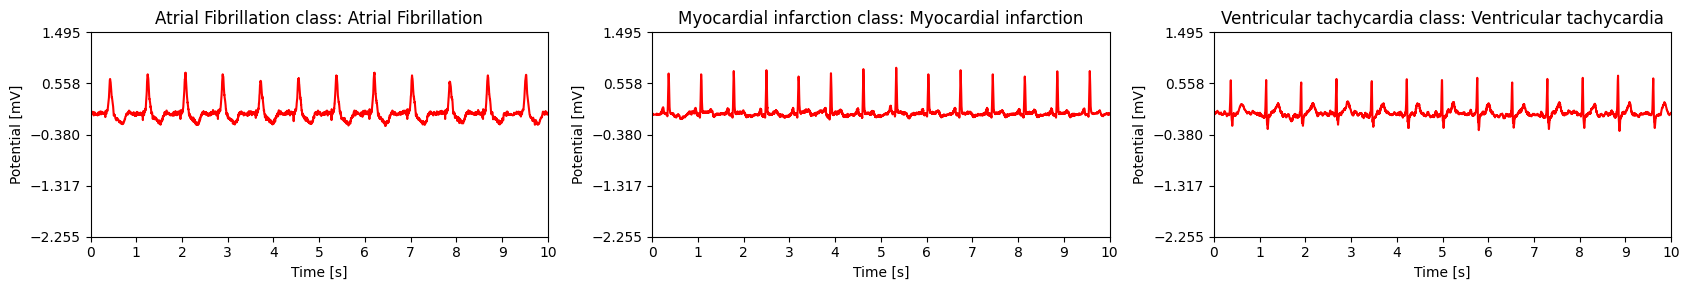

In [5]:
import wfdb
import numpy as np
import os
from matplotlib import pyplot as plt

df_set = label_set  # Assuming this contains the unique class labels

def fetch_mimic_data(index_list, sequence_length):
    """
    Fetch 12-lead ECG data for the given indices, ensuring consistent sequence length.
    Pads shorter signals with zeros and truncates longer ones.
    """
    data = []
    for idx in index_list:
        record_path = os.path.join(data_root, records_df.iloc[idx]['path'])
        try:
            ecg_data, _ = wfdb.rdsamp(record_path)
            
            # Process all 12 leads
            leads_data = []
            for lead in range(ecg_data.shape[1]):
                padded_data = np.zeros(sequence_length)
                sig_len = min(sequence_length, ecg_data.shape[0])
                padded_data[:sig_len] = ecg_data[:sig_len, lead]
                leads_data.append(padded_data)
            
            data.append(np.stack(leads_data, axis=0))  # Stack leads for each sample
        except FileNotFoundError:
            print(f"File not found: {record_path}")
            continue
    
    return np.array(data)  # Shape: [samples, 12 leads, sequence_length]

def get_sample(n_samples=1):
    """
    Randomly sample indices for each class in `df_set`.
    """
    fid_list = [np.random.choice(records_df[records_df.icd_title == label].index, n_samples, replace=False)
                for label in df_set]
    return np.concatenate(fid_list)

# Sampling and visualization
name_list = get_sample()  # One sample per class
slen = 5000  # 10 seconds of data at 500 Hz
data = fetch_mimic_data(name_list, sequence_length=slen)
time = np.arange(0, slen) / 500  # Time axis for 500 Hz sampling frequency

# Plot ECG data
fig, ax = plt.subplots(1, len(name_list), figsize=(17, 3))

# Dynamic y-axis range
y_min, y_max = np.min(data), np.max(data)
for i, ax1 in enumerate(ax):
    ax1.plot(time, data[i][0], color='r')  # Plot the first lead (Lead I)
    ax1.set(xlim=[0, 10], xticks=np.arange(0, 11, 1),
            ylim=[y_min, y_max], yticks=np.linspace(y_min, y_max, 5),
            xlabel='Time [s]', ylabel='Potential [mV]')
    ax1.set_title(records_df.iloc[name_list[i]]['icd_title'] + ' class: ' + df_set[i])

plt.tight_layout()
plt.show()


Unique sampling rates in dataset: [500]
Unique gain settings in dataset: ['mV']
Unique baseline settings: [0]
Sequence lengths [min, max]: [5000, 5000]
Recording times in seconds [min, max]: [10.000, 10.000]


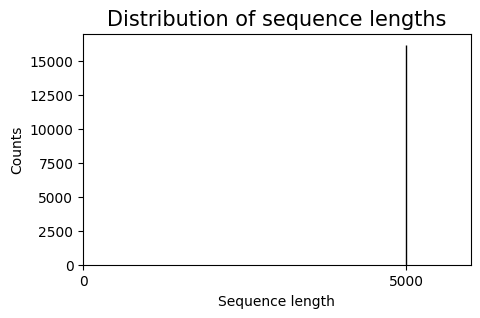

In [6]:
import seaborn as sns
import wfdb
import numpy as np
import os
import matplotlib.pyplot as plt

def mimic_parameters(records_df, base_path):
    """
    Extract parameters from the MIMIC-IV ECG dataset files.
    """
    sequence_lengths = []
    sampling_rates = []
    baselines = []
    gains = []
    recording_times = []
    
    for idx, row in records_df.iterrows():
        ecg_file_path = os.path.normpath(os.path.join(base_path, row['path']))
        try:
            ecg_data, fields = wfdb.rdsamp(ecg_file_path)

            # Sequence length
            sequence_length = ecg_data.shape[0]
            sequence_lengths.append(sequence_length)

            # Sampling rate
            sampling_rate = fields['fs'] if 'fs' in fields else 300  # Default to 300 Hz
            sampling_rates.append(sampling_rate)

            # Baseline
            baseline = fields['baseline'] if 'baseline' in fields else 0
            baselines.append(baseline)

            # Gain/Units
            gain = fields['units'] if 'units' in fields else 'mV'
            gains.append(gain)

            # Recording time
            recording_time = sequence_length / sampling_rate
            recording_times.append(recording_time)
        
        except FileNotFoundError:
            print(f"File not found: {ecg_file_path}")
            continue
    
    return sequence_lengths, sampling_rates, recording_times, baselines, gains


# Analyze parameters
sequence_lengths, sampling_rates, recording_times, baselines, gains = mimic_parameters(records_df, data_root)

sequence_length_min, sequence_length_max = np.min(sequence_lengths), np.max(sequence_lengths)
recording_time_min, recording_time_max = np.min(recording_times), np.max(recording_times)

print('Unique sampling rates in dataset:', np.unique(sampling_rates))
print('Unique gain settings in dataset:', np.unique(gains))
print('Unique baseline settings:', np.unique(baselines))
print('Sequence lengths [min, max]:', [sequence_length_min, sequence_length_max])
print('Recording times in seconds [min, max]: [%.3f, %.3f]' % (recording_time_min, recording_time_max))

# Plot a histogram of sequence lengths
fig = plt.figure(figsize=(5, 3))
sns.histplot(sequence_lengths, kde=False, color='red', bins='auto')  # Dynamically adjust bins
plt.xlabel('Sequence length')
plt.xlim([0, sequence_length_max + 1000])
plt.xticks(np.arange(0, sequence_length_max + 2000, 5000))
plt.ylabel('Counts')
plt.title('Distribution of sequence lengths', fontsize=15)
plt.show()

# Check for consistent sampling rate
if len(np.unique(sampling_rates)) > 1:
    print("Warning: Multiple sampling rates detected. Ensure consistency.")

# Ensure consistent units
if len(np.unique(gains)) > 1:
    print("Warning: Multiple gain settings detected.")

# Set sampling rate and sequence length for further processing
fs = sampling_rates[0]  # Assuming a consistent sampling rate
sequence_length = sequence_length_max


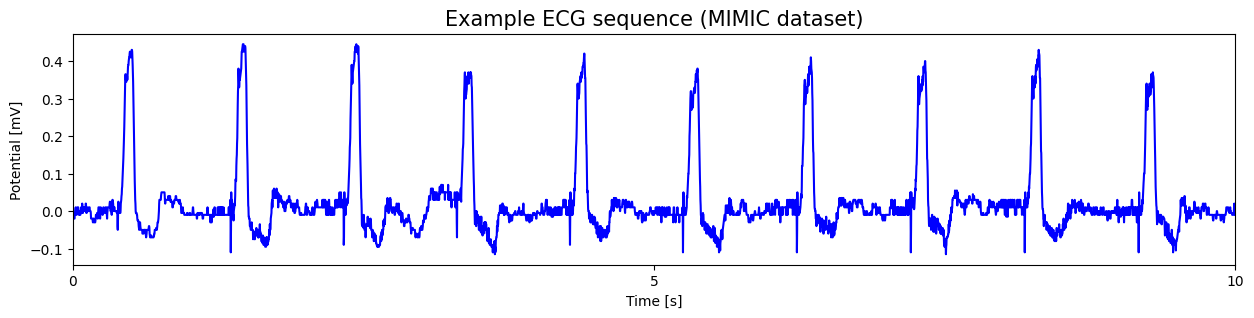

In [7]:
record_path = records_df.iloc[15]['path']
ecg_file_path = os.path.join(data_root, record_path)

# Read ECG data
ecg_data, fields = wfdb.rdsamp(ecg_file_path)

# Use all available data for Lead I (or another specific lead)
ts = ecg_data[:, 0]  # Lead I
fs = fields['fs'] if 'fs' in fields else 500  # Ensure correct sampling rate (default to 500 Hz)

# Generate the time axis for the signal
time = np.arange(0, len(ts)) / fs

# Plot the ECG sequence
fig, ax1 = plt.subplots(figsize=(15, 3))
ax1.plot(time, ts, 'b')
ax1.set(xlabel='Time [s]', xlim=[0, time[-1]], xticks=np.arange(0, time[-1] + 5, 5))
ax1.set(ylabel='Potential [mV]')
plt.title('Example ECG sequence (MIMIC dataset)', fontsize=15)

plt.show()


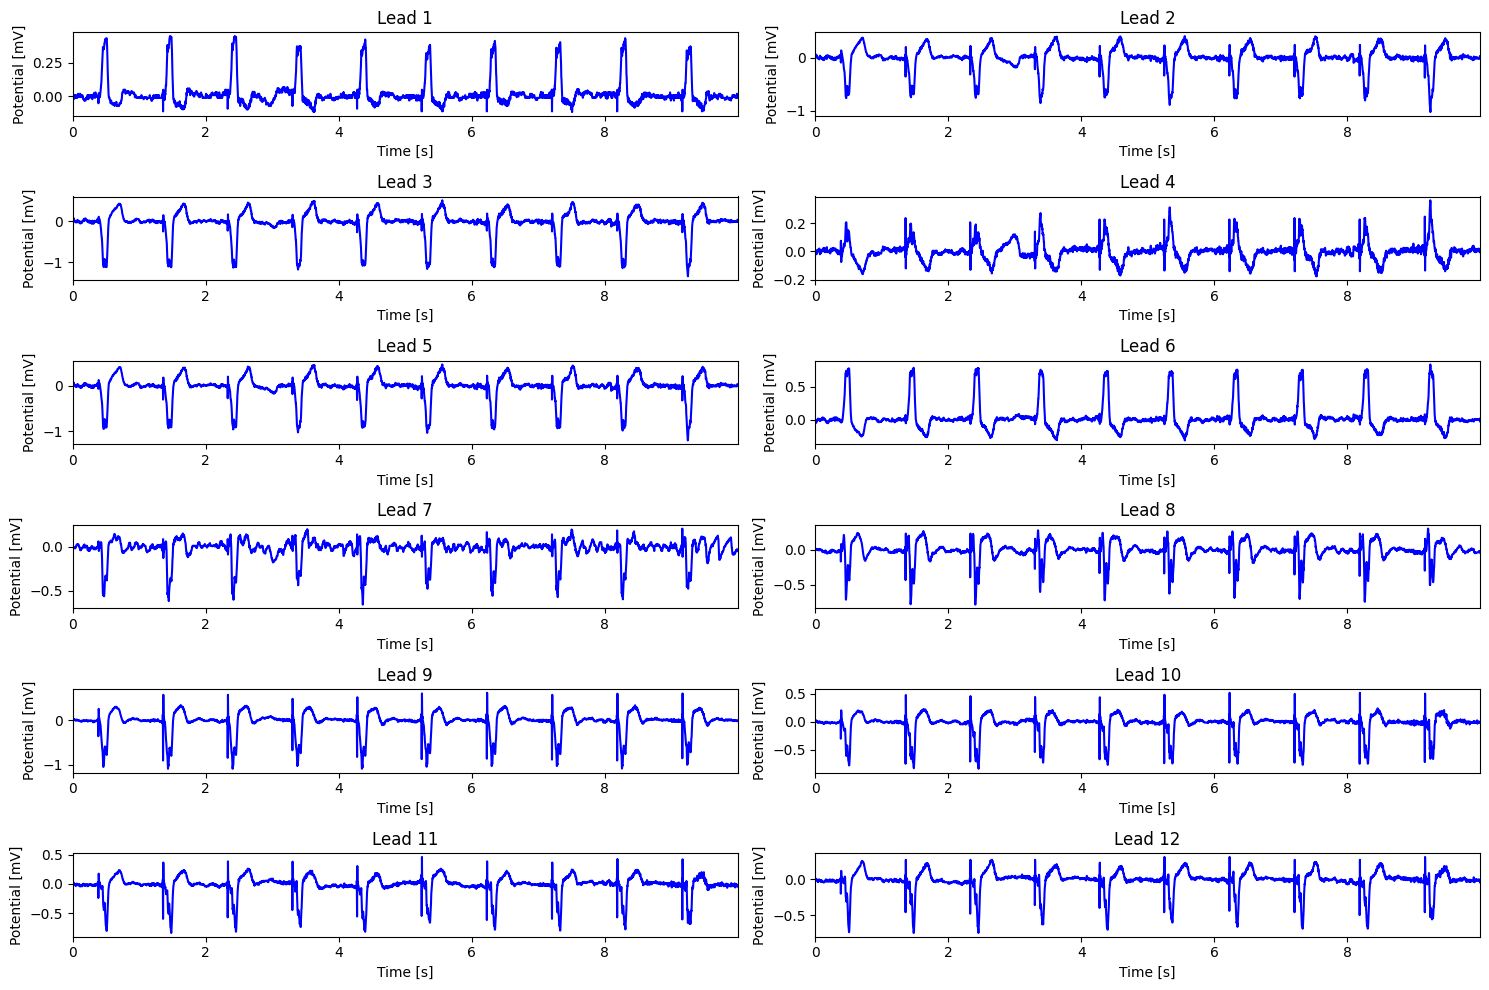

In [8]:
# Plot all 12 leads
fig, axes = plt.subplots(6, 2, figsize=(15, 10))  # 6x2 grid for 12 leads
axes = axes.flatten()

for lead_idx in range(12):
    ts = ecg_data[:, lead_idx]  # Data for the current lead
    time = np.arange(0, len(ts)) / fs
    
    # Plot each lead
    axes[lead_idx].plot(time, ts, 'b')
    axes[lead_idx].set(xlabel='Time [s]', ylabel='Potential [mV]', title=f'Lead {lead_idx + 1}')
    axes[lead_idx].set(xlim=[0, time[-1]])

plt.tight_layout()
plt.show()


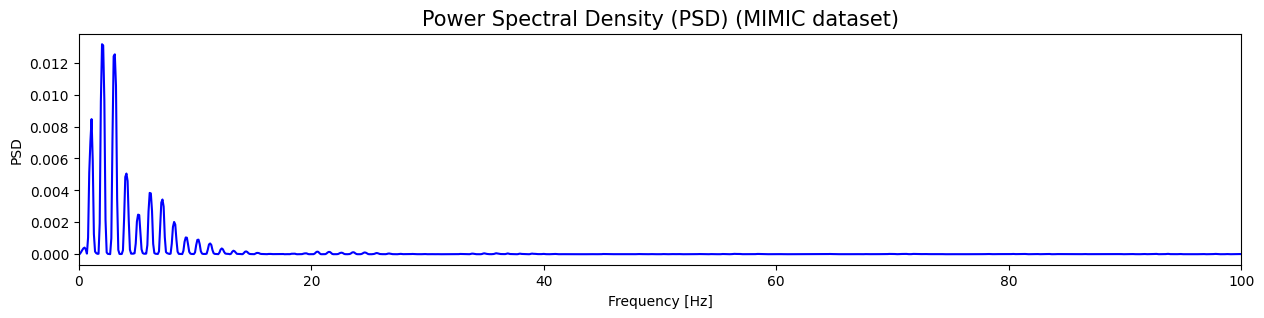

In [9]:
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np

# Assuming `ts` contains the raw signal for a single lead (e.g., Lead I)
# and `fs` is the sampling frequency (500 Hz for MIMIC-IV dataset)

# Compute Power Spectral Density (PSD)
f1, PSD = signal.periodogram(ts, fs, window='flattop', scaling='density')

# Plot the PSD
fig, ax1 = plt.subplots(figsize=(15, 3))
ax1.plot(f1, PSD, 'b')
ax1.set(xlabel='Frequency [Hz]', xlim=[0, 100], xticks=np.arange(0, 101, 20))  # Focus on 0-100 Hz range
ax1.set(ylabel='PSD')
plt.title('Power Spectral Density (PSD) (MIMIC dataset)', fontsize=15)

plt.show()


In [10]:
from physionet_processing import spectrogram
import matplotlib.pyplot as plt
import numpy as np

# Assuming `ts` is the raw signal for a single lead (e.g., Lead I) and fs is the sampling frequency (500 Hz)
ts_reshaped = np.expand_dims(ts, axis=0)  # Reshape to match spectrogram input format [1, sequence_length]

# Compute spectrograms
f, t, Sx = spectrogram(ts_reshaped, log_spectrogram=False)
_, _, Sx_log = spectrogram(ts_reshaped, log_spectrogram=True)

# Visualization
im_list = [Sx[0], Sx_log[0]]
im_title = ['Spectrogram without log transform', 'Spectrogram with log transform']
fig, ax_list = plt.subplots(1, 2, figsize=(15, 3))

for i, ax in enumerate(ax_list):
    ax.imshow(np.transpose(im_list[i]), aspect='auto', cmap='jet')
    ax.grid(False)
    ax.invert_yaxis()
    ax.set_title(im_title[i], fontsize=12)
    ax.set(ylim=[0, im_list[i].shape[1]], yticks=np.arange(0, im_list[i].shape[1] + 1, 5))
    ax.set(xlabel='Time [s]', ylabel='Frequency [Hz]')
    
    # Time ticks and labels
    xticks_array = np.arange(0, im_list[i].shape[0] + 1, 100)
    ax.set(xlim=[0, im_list[i].shape[0]], xticks=xticks_array)
    labels_new = [str(np.around(t[label], decimals=1)) for label in xticks_array if label < len(t)]
    ax.set_xticklabels(labels_new)
    ax.tick_params(axis='x', which='both', bottom=False)
    ax.tick_params(axis='y', which='both', left=False)

plt.tight_layout()
plt.show()


ValueError: not enough values to unpack (expected 3, got 1)

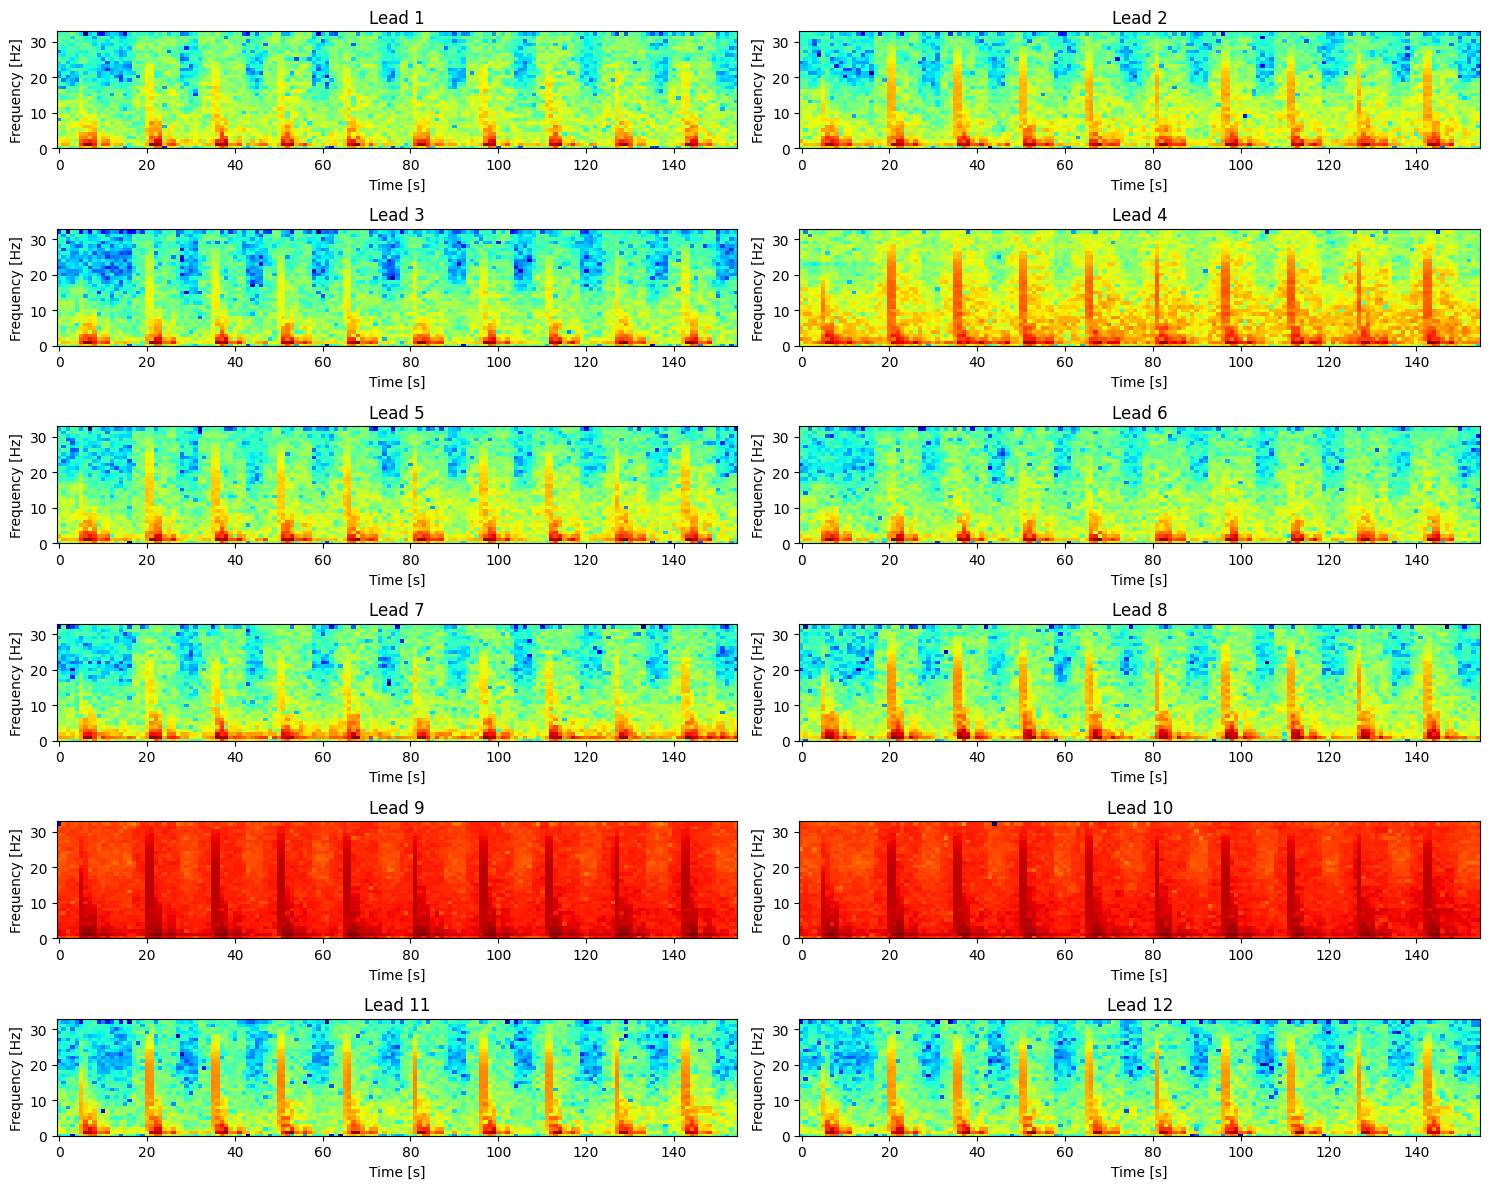

In [30]:
# Assuming `ecg_data` contains the raw 12-lead ECG signal
fig, axes = plt.subplots(6, 2, figsize=(15, 12))  # 6x2 grid for 12 leads
axes = axes.flatten()

for lead_idx in range(12):
    ts_reshaped = np.expand_dims(ecg_data[:, lead_idx], axis=0)  # Reshape to match spectrogram input format
    f, t, Sx = spectrogram(ts_reshaped, log_spectrogram=True)
    
    # Plot spectrogram for the current lead
    ax = axes[lead_idx]
    ax.imshow(np.transpose(Sx[0]), aspect='auto', cmap='jet')
    ax.grid(False)
    ax.invert_yaxis()
    ax.set_title(f'Lead {lead_idx + 1}', fontsize=12)
    ax.set(ylim=[0, Sx[0].shape[1]], xlabel='Time [s]', ylabel='Frequency [Hz]')

plt.tight_layout()
plt.show()


In [107]:
'Generates data for PyTorch using MIMIC dataset'
def __init__(self, data_dir, records_df, list_IDs, labels, batch_size=32, dim=(178, 33), 
             nperseg=64, noverlap=32, n_channels=1, sequence_length=5736,
             n_classes=3, shuffle=True, augment=False):
    
    'Initialization'
    self.data_dir = data_dir  
    self.records_df = records_df 
    self.list_IDs = list_IDs  
    self.labels = labels  
    self.batch_size = batch_size  
    self.dim = dim  
    self.nperseg = nperseg  
    self.noverlap = noverlap
    self.n_channels = n_channels  
    self.sequence_length = sequence_length  
    self.n_classes = n_classes 
    self.shuffle = shuffle 
    self.augment = augment  
    self.on_epoch_end() 


In [108]:
# import keras

# def __data_generation(self, list_IDs_temp):
#     'Generates data containing batch_size samples'  
#     X = np.empty((self.batch_size, *self.dim, self.n_channels), dtype=float)
#     y = np.empty((self.batch_size), dtype=int)

#     for i, ID in enumerate(list_IDs_temp):
#         record = self.records_df[self.records_df['study_id'] == ID].iloc[0]
#         ecg_file_path = os.path.join(self.data_dir, record['path'])

#         ecg_data, _ = wfdb.rdsamp(ecg_file_path)
#         ecg_data = ecg_data[:, 0]  # Use Lead I

#         data = extend_ts(ecg_data, self.sequence_length)
#         data = np.reshape(data, (1, len(data)))

#         if self.augment:
#             data = zero_filter(data, threshold=2, depth=10)

#             data = random_resample(data)

#         data_spectrogram = spectrogram(data, nperseg=self.nperseg, noverlap=self.noverlap)[2]

#         data_norm = (data_spectrogram - np.mean(data_spectrogram)) / np.std(data_spectrogram)

#         X[i,] = np.expand_dims(data_norm, axis=3)

#         y[i] = self.labels[ID]

#     return X, keras.utils.to_categorical(y, num_classes=self.n_classes)


In [33]:
max_length = sequence_length  # Max signal length for compatibility (not extended or padded)
spectrogram_nperseg = 64      # Spectrogram parameters
spectrogram_noverlap = 32
n_classes = len(records_df['icd_title'].unique())  # Number of unique classes in the dataset
batch_size = 32

# Select a sample record for demonstration
sample_record = records_df.iloc[0]  
ecg_file_path = os.path.join(data_root, sample_record['path'])  

# Read ECG data (assuming 12-lead data)
ecg_data, _ = wfdb.rdsamp(ecg_file_path)
ecg_data = ecg_data[:, 0]  # Use Lead I for demonstration (can be changed to another lead)

# Compute the spectrogram directly from raw data
Sx_log = spectrogram(np.expand_dims(ecg_data, axis=0),
                     nperseg=spectrogram_nperseg,
                     noverlap=spectrogram_noverlap,
                     log_spectrogram=True)[2]

# Get spectrogram dimensions
dim = Sx_log[0].shape

print(f"Spectrogram dimension (Height, Width): {dim}")


Spectrogram dimension (Height, Width): (155, 33)


In [35]:
from physionet_generator import DataGenerator

# Parameters for the DataGenerator class
params = {
    'batch_size': batch_size,  # Number of samples per batch
    'dim': dim,  # Spectrogram dimensions (time_steps, frequency_bins)
    'nperseg': spectrogram_nperseg,  # Spectrogram parameter
    'noverlap': spectrogram_noverlap,  # Spectrogram parameter
    'n_channels': 12,  # Number of ECG leads
    'sequence_length': sequence_length,  # Signal length
    'n_classes': n_classes,  # Number of classes for classification
    'shuffle': True  # Shuffle data after each epoch
}

# Initialize training and validation generators
train_generator = DataGenerator(records_df, data_root, partition['train'], labels, augment=True, **params)
val_generator = DataGenerator(records_df, data_root, partition['validation'], labels, augment=False, **params)

# Fetch a single batch for inspection
try:
    for i, batch in enumerate(train_generator):
        if i == 1:  # Stop after the first batch
            break
except Exception as e:
    print("Error during batch generation:", str(e))

# Extract input data (X) and labels (y)
X, y = batch

# Print details about the batch
print('Batch details:')
print('X shape:', X.shape)  # Shape of spectrogram batch (batch_size, time_steps, frequency_bins, 12)
print('y shape:', y.shape)  # Shape of label batch (batch_size, n_classes)
print('Data type of X:', X.dtype)  # Type of spectrogram data


Batch details:
X shape: (32, 155, 33, 12)
y shape: (32, 3)
Data type of X: float64


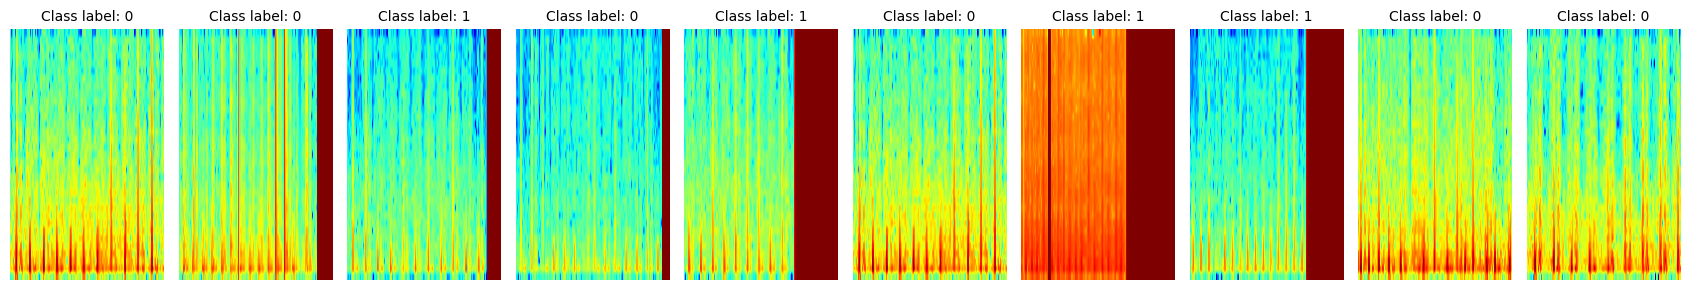

In [36]:
def imshow_batch(X, y, batch_idx, lead_idx=0):
    """
    Visualizes a batch of spectrograms and their corresponding class labels.
    
    Parameters:
        X (ndarray): Batch of spectrogram data with shape (batch_size, time_steps, frequency_bins, n_channels).
        y (ndarray): Corresponding one-hot encoded labels with shape (batch_size, n_classes).
        batch_idx (list): List of indices from the batch to visualize.
        lead_idx (int): Lead index to visualize (default is 0 for Lead I).
    
    Returns:
        fig (Figure): Matplotlib figure containing the visualizations.
    """
    batch_labels = ['Class label: ' + str(np.argmax(y[idx,])) for idx in batch_idx]

    fig, ax = plt.subplots(1, len(batch_idx), figsize=(17, 3))  # Adjust figure height for better visibility

    for i, idx in enumerate(batch_idx):
        ax[i].imshow(X[idx, :, :, lead_idx].transpose(), cmap='jet', aspect='auto')
        ax[i].grid(False)
        ax[i].axis('off')
        ax[i].invert_yaxis()
        ax[i].set_title(batch_labels[i], fontsize=10)

    plt.tight_layout()
    plt.show()
    
    return fig

# Generate random indices for visualization
batch_idx = np.random.randint(0, batch_size, size=10)

# Visualize a subset of the batch
fig = imshow_batch(X, y, batch_idx, lead_idx=0)  # Default to Lead I


In [64]:
def conv2d_block(model, depth=4, layer_filters=32, growth_rate=32, 
                 strides_start=(1, 1), strides_end=(2, 2), input_shape=None, first_layer=False):
    """
    Builds a convolutional block with batch normalization and ReLU activation.
    
    Parameters:
        model (Sequential): Keras Sequential model to which the layers will be added.
        depth (int): Number of convolutional layers in the block.
        layer_filters (int): Initial number of filters in the block.
        growth_rate (int): Number of filters added in the last layer.
        strides_start (tuple): Strides for all layers except the last.
        strides_end (tuple): Strides for the last layer (e.g., for down-sampling).
        input_shape (tuple): Input shape for the first layer (e.g., (height, width, channels)).
        first_layer (bool): If True, adds input_shape to the first layer.
    
    Returns:
        Sequential: Updated model with the convolutional block.
    """
    conv_params = {
        'kernel_size': (3, 3),
        'padding': 'same',
        'dilation_rate': (1, 1),
        'activation': None,
        'data_format': 'channels_last',
        'kernel_initializer': 'glorot_normal'
    }

    for l in range(depth):
        if first_layer and l == 0:
            # Add input shape to the first layer
            model.add(layers.Conv2D(filters=layer_filters,
                                    strides=strides_start,
                                    input_shape=input_shape, **conv_params))
        else:
            # Add layers with adjusted strides
            strides = strides_end if l == depth - 1 else strides_start
            filters = layer_filters + (growth_rate if l == depth - 1 else 0)
            model.add(layers.Conv2D(filters=filters, strides=strides, **conv_params))

        # Add batch normalization and activation
        model.add(layers.BatchNormalization(center=True, scale=True))
        model.add(layers.Activation('relu'))

    return model


In [65]:
from keras import layers
from tensorflow.keras import backend as K  # Correct backend import

def MeanOverTime(axis=1):
    """
    Creates a Lambda layer to compute the mean along the specified axis.

    Parameters:
        axis (int): The axis along which to compute the mean.

    Returns:
        Lambda: A Keras Lambda layer.
    """
    return layers.Lambda(lambda x: K.mean(x, axis=axis), output_shape=lambda s: s[:axis] + s[axis + 1:])


In [66]:
filters_start = 32 # Number of convolutional filters
layer_filters = filters_start # Start with these filters
filters_growth = 32 # Filter increase after each convBlock
strides_start = (1, 1) # Strides at the beginning of each convBlock
strides_end = (2, 2) # Strides at the end of each convBlock
depth = 4 # Number of convolutional layers in each convBlock
n_blocks = 6 # Number of ConBlocks
n_channels = 1 # Number of color channgels
dim = (155, 33)  # Replace with actual dimensions of your spectrogram
input_shape = (*dim, n_channels)  # Example: (156, 33, 1)


In [67]:
from keras.models import Sequential

# Define the required parameters
n_blocks = 6  # Number of convolutional blocks
depth = 4  # Depth of each convolutional block (number of layers per block)
layer_filters = 32  # Initial number of filters
filters_growth = 32  # Number of filters added after each block
strides_start = (1, 1)  # Strides for intermediate layers
strides_end = (2, 2)  # Strides for down-sampling at the end of each block
input_shape = (155, 33, 12)  # Input shape for 12-lead spectrograms (time_steps, frequency_bins, 12 leads)

# Initialize the Sequential model
model = Sequential()

# Loop through convolutional blocks
for block in range(n_blocks):
    # Only the first block requires input shape
    provide_input = block == 0

    # Add a convolutional block
    model = conv2d_block(
        model=model,
        depth=depth,
        layer_filters=layer_filters,
        strides_start=strides_start,
        strides_end=strides_end,
        input_shape=input_shape if provide_input else None,  # Input shape only for the first block
        first_layer=provide_input
    )

    # Increase the number of filters for the next block
    layer_filters += filters_growth


In [56]:
previous_output_shape = (batch_size, X, 224)


In [68]:
model.add(layers.Reshape((-1, 224)))
model.add(layers.Masking(mask_value = 0.0))
model.add(MeanOverTime())
model.add(layers.Dense(3, activation='sigmoid', kernel_regularizer = regularizers.l2(0.1)))


model.summary()

c:\Users\nazrulsa\Downloads\test\.venv\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'lambda_2' (of type Lambda) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_48 (Conv2D)              │ (None, 155, 33, 32)    │         3,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_48          │ (None, 155, 33, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_48 (Activation)      │ (None, 155, 33, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_49 (Conv2D)              │ (None, 155, 33, 32)    │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_49          │ (None, 155, 33, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_49 (Activation)      │ (None, 155, 33, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_50 (Conv2D)              │ (None, 155, 33, 32)    │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_50          │ (None, 155, 33, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_50 (Activation)      │ (None, 155, 33, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_51 (Conv2D)              │ (None, 78, 17, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_51          │ (None, 78, 17, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_51 (Activation)      │ (None, 78, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_52 (Conv2D)              │ (None, 78, 17, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_52          │ (None, 78, 17, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_52 (Activation)      │ (None, 78, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_53 (Conv2D)              │ (None, 78, 17, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_53          │ (None, 78, 17, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_53 (Activation)      │ (None, 78, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_54 (Conv2D)              │ (None, 78, 17, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_54          │ (None, 78, 17, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_54 (Activation)      │ (None, 78, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 3,557,475 (13.57 MB)

 Trainable params: 3,551,715 (13.55 MB)

 Non-trainable params: 5,760 (22.50 KB)

In [69]:
for X_batch, y_batch in train_generator:
    print(f"Input shape: {X_batch.shape}")
    print(f"Label shape: {y_batch.shape}")
    break


Input shape: (32, 155, 33, 12)
Label shape: (32, 3)


In [70]:
def smoothcols(df, cols):
    
    lfrac = 0.02
    lowess = sm.nonparametric.lowess
    df_sm = df.copy()
    x = df.epoch.values

    # Replace columns with smoothed values
    for c in cols:
        df_sm[c]  = lowess(df[c].values, x, frac = lfrac)[:,1]
        
    return df_sm

In [71]:
from keras import optimizers

# Compile the model with Adam optimizer and categorical crossentropy loss
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(learning_rate=0.001),  
              metrics=['acc'])


In [11]:
history = model.fit(
    train_generator,
    steps_per_epoch=50,
    epochs=10,
    validation_data=val_generator,
    validation_steps=50
)


NameError: name 'model' is not defined

: 